# compare

In [1]:
import pkufiber as pf
import matplotlib.pyplot as plt, numpy as np
from pkufiber.data.loader import FiberDataset
# path = '/home/xiaoxinyu/dataset/test.h5'
path = '/home/xiaoxinyu/TorchFiber/dataset_A800/test.h5'
# path = '/gpfs/share/home/2001110035/TorchFiber/dataset/test.h5'


def get_data(path, pchs, method='CDC'):
    q_list = []
    for pch in pchs:
        data = FiberDataset(path, Nch=3, Rs=80, Pch=pch, Nmodes=2,
                        window_size=80000, strides=1, num_symb=80000, truncate=10000, 
                        Tx_window=True, pre_transform=f'Rx_{method}DDLMS(taps=32,lr=[0.015625, 0.0078125])')
        Rx,Tx, info = data[0]
        q_list.append(pf.qfactor_all(Rx, Tx))
    return q_list

In [12]:
net = pf.dsp.nonlinear_compensation.EqCNNBiLSTM(M=41, Nmodes=2,channels=8, kernel_size=11, hidden_size=20, num_layers=1)

# 计算net的参数量
sum(p.numel() for p in net.parameters())

10120

In [7]:
from pkufiber.dsp.layers import ComplexConv1d
import torch 
x = torch.rand(10, 2, 100, dtype=torch.complex64)
ComplexConv1d(in_channels=2, out_channels=4, kernel_size=100)(x).squeeze().shape

torch.Size([10, 4])

In [2]:
pchs = [6]
q1 = get_data(path, pchs, 'CDC')
q1

[3.756731080499771]

In [9]:
pchs = [6]
q1 = get_data(path, pchs, 'DBP64')
q1

[7.990755613252649]

In [33]:
path = '/home/xiaoxinyu/dataset/test.h5'
q2 = get_data(path, 'CDC')
print(q2)

[7.604331574418768]


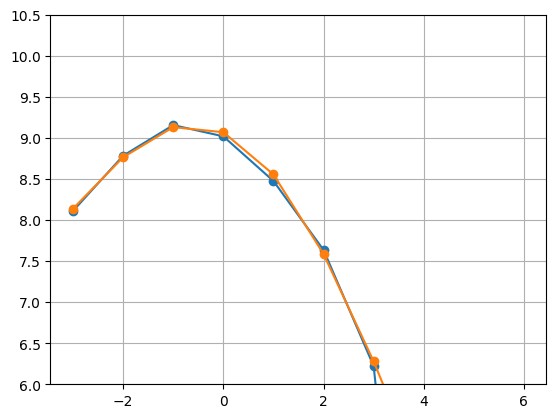

In [16]:
plt.plot(range(-3, 7), q1, '-o')
plt.plot(range(-3, 7), q2, '-o')
plt.ylim(6, 10.5)
plt.grid()

# PBC

In [24]:
import pkufiber as pf 
import pkufiber.dsp.nonlinear_compensation as nl
import pkufiber.dsp.nonlinear_compensation.pbc as pbc
import pkufiber.dsp.nonlinear_compensation.nneq as eq
import torch 
from torch.utils.data import DataLoader

train_path = '/home/xiaoxinyu/TorchFiber/dataset_A800/train.h5'
test_path = '/home/xiaoxinyu/TorchFiber/dataset_A800/test.h5'   

window_size = 81
Nmodes = 2
num_symb = 320000
index_type = pbc.IndexType.full


def get_loader(path):
    train_data = pf.data.PbcDataset(path=path, Nmodes=Nmodes, Nch=1, Rs=40, Pch=2, window_size=window_size, num_symb=num_symb)
    train_loader = DataLoader(train_data, batch_size=num_symb-400, shuffle=False)
    Rx_window, Tx, info = next(iter(train_loader))
    P = pf.get_power(info, Nmodes=2, device='cpu')
    return Rx_window, Tx, P, info

def feature_extraction(Rx_window, P):
    net = pbc.TripletFeatures(M=window_size, rho=40, index_type=index_type)
    symbol_features = Rx_window.transpose(1,2)                                        # [N, Nmodes, M]
    pbc_features = net.nonlinear_features(Rx_window[...,None]).squeeze(2) * P[:,None,None]   # [N, Nmodes, p]
    features = torch.cat([pbc_features], dim=2)                                           # [N, Nmodes, M+p]
    # features = torch.cat([symbol_features, pbc_features], dim=2)                            # [N, Nmodes, *]
    return features, net.index


def test(coeffs):
    Rx_window, Tx, P, info = get_loader(test_path)
    Rx = Rx_window[:,Rx_window.size(1)//2]

    features, index = feature_extraction(Rx_window, P)
    bias_hat = pbc.predict(coeffs,features)

    print('CDC Q factor:', pf.ber(Rx, Tx)['Qsq'])
    print('PBC Q factor:', pf.ber(Rx + bias_hat, Tx)['Qsq'])


def train(p=2):
    # data
    Rx_window, Tx, P, info = get_loader(train_path)
    Rx = Rx_window[:,Rx_window.size(1)//2]
    bias = Tx - Rx

    # fit data
    features, index = feature_extraction(Rx_window, P)
    weight = pbc.kernel(features, bias, None, p=p)
    coeffs = pbc.fit(features, bias, weight=weight, pol_sep=True, lamb_l2=0.1)

    return coeffs, index


In [27]:
index_type = pbc.IndexType.full
coeffs, index = train(p=2)

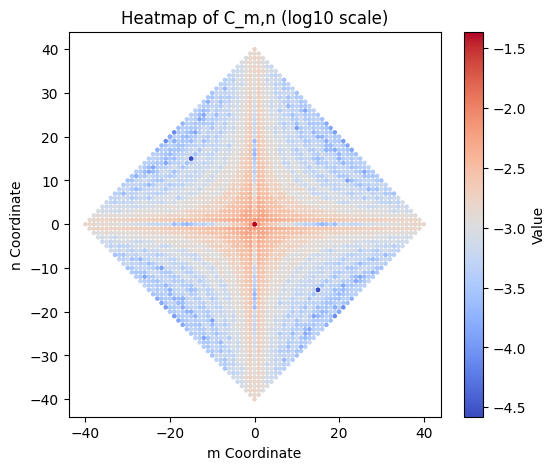

In [26]:
pbc.show_pbc(coeffs[0], index, index_type=index_type, figsize=(6, 5), s=5)

In [16]:
C = {key:value for key, value in zip(index, coeffs[0].detach().numpy())}

In [31]:
# data
Rx_window, Tx, P,info = get_loader(train_path)
Rx = Rx_window[:,20]
bias = Tx - Rx
new_bias = bias - pbc.predict(coeffs, feature_extraction(Rx_window, P))

In [32]:
net = eq.EqCNNBiLSTM(41, 2, 64, 11, 40, 1)
optmizer = torch.optim.Adam(net.parameters(), lr=0.01)

net = net.to('cuda:0')
Rx_window = Rx_window.to('cuda:0')
new_bias = new_bias.to('cuda:0')

In [ ]:
loss_list = []
for i in range(400):
    optmizer.zero_grad()
    output = net(Rx_window, info)    
    loss = pf.mse(new_bias, 0.1 * output)
    loss.backward()
    optmizer.step()
    loss_list.append(loss.item())
    if i % 20 == 0:
        print(f'epoch {i}: ', loss.item())

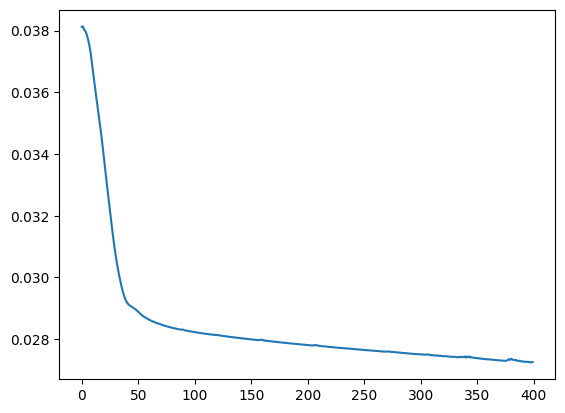

In [14]:
import matplotlib.pyplot as plt 

plt.plot(loss_list)

In [26]:
# data
Rx_window, Tx, P,info = get_loader(train_path)
Rx = Rx_window[:,20]
bias = Tx - Rx

In [27]:
pf.ber(Rx, Tx)

{'BER': array([0.0089925, 0.008735 ], dtype=float32),
 'SER': array([0.03554, 0.03444], dtype=float32),
 'Qsq': array([7.480026, 7.519355], dtype=float32),
 'SNR': array([14.457268, 14.488782], dtype=float32)}

In [28]:
Rx_hat = Rx + pbc.predict(coeffs, feature_extraction(Rx_window.cpu(), P))
pf.ber(Rx_hat, Tx)

{'BER': array([0.0044   , 0.0044575], dtype=float32),
 'SER': array([0.01756, 0.01777], dtype=float32),
 'Qsq': array([8.365124, 8.350419], dtype=float32),
 'SNR': array([15.4832325, 15.461325 ], dtype=float32)}

In [29]:
Rx_hat = Rx + pbc.predict(coeffs, feature_extraction(Rx_window.cpu(), P)) + net(Rx_window.cuda(), info).cpu()*0.1
pf.ber(Rx_hat, Tx)

{'BER': array([0.00367  , 0.0036575], dtype=float32),
 'SER': array([0.01464, 0.01457], dtype=float32),
 'Qsq': array([8.565973, 8.569672], dtype=float32),
 'SNR': array([15.656148, 15.64169 ], dtype=float32)}